### Using Colab
Google Colab is used for the assignment as the local system was running out of memory or was unuseable for the time the code was running. If a re-running is indeed required, it is recommended to use Colab instead of running it locally. The code cell underneath is used to mount the user's drive account. **If the user does not want to use Colab and wants to run the notebook locally, the first two cells can be commented and the other cells run.**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Drive Directory Structure
It is assumed that the notebook is located in a folder named *Colab Notebooks* in the user's Google Drive account. The image files are assumed to be present in a folder named *data* within the *Colab Notebooks* folder. Two screenshots of the browser window are provided for guidance.

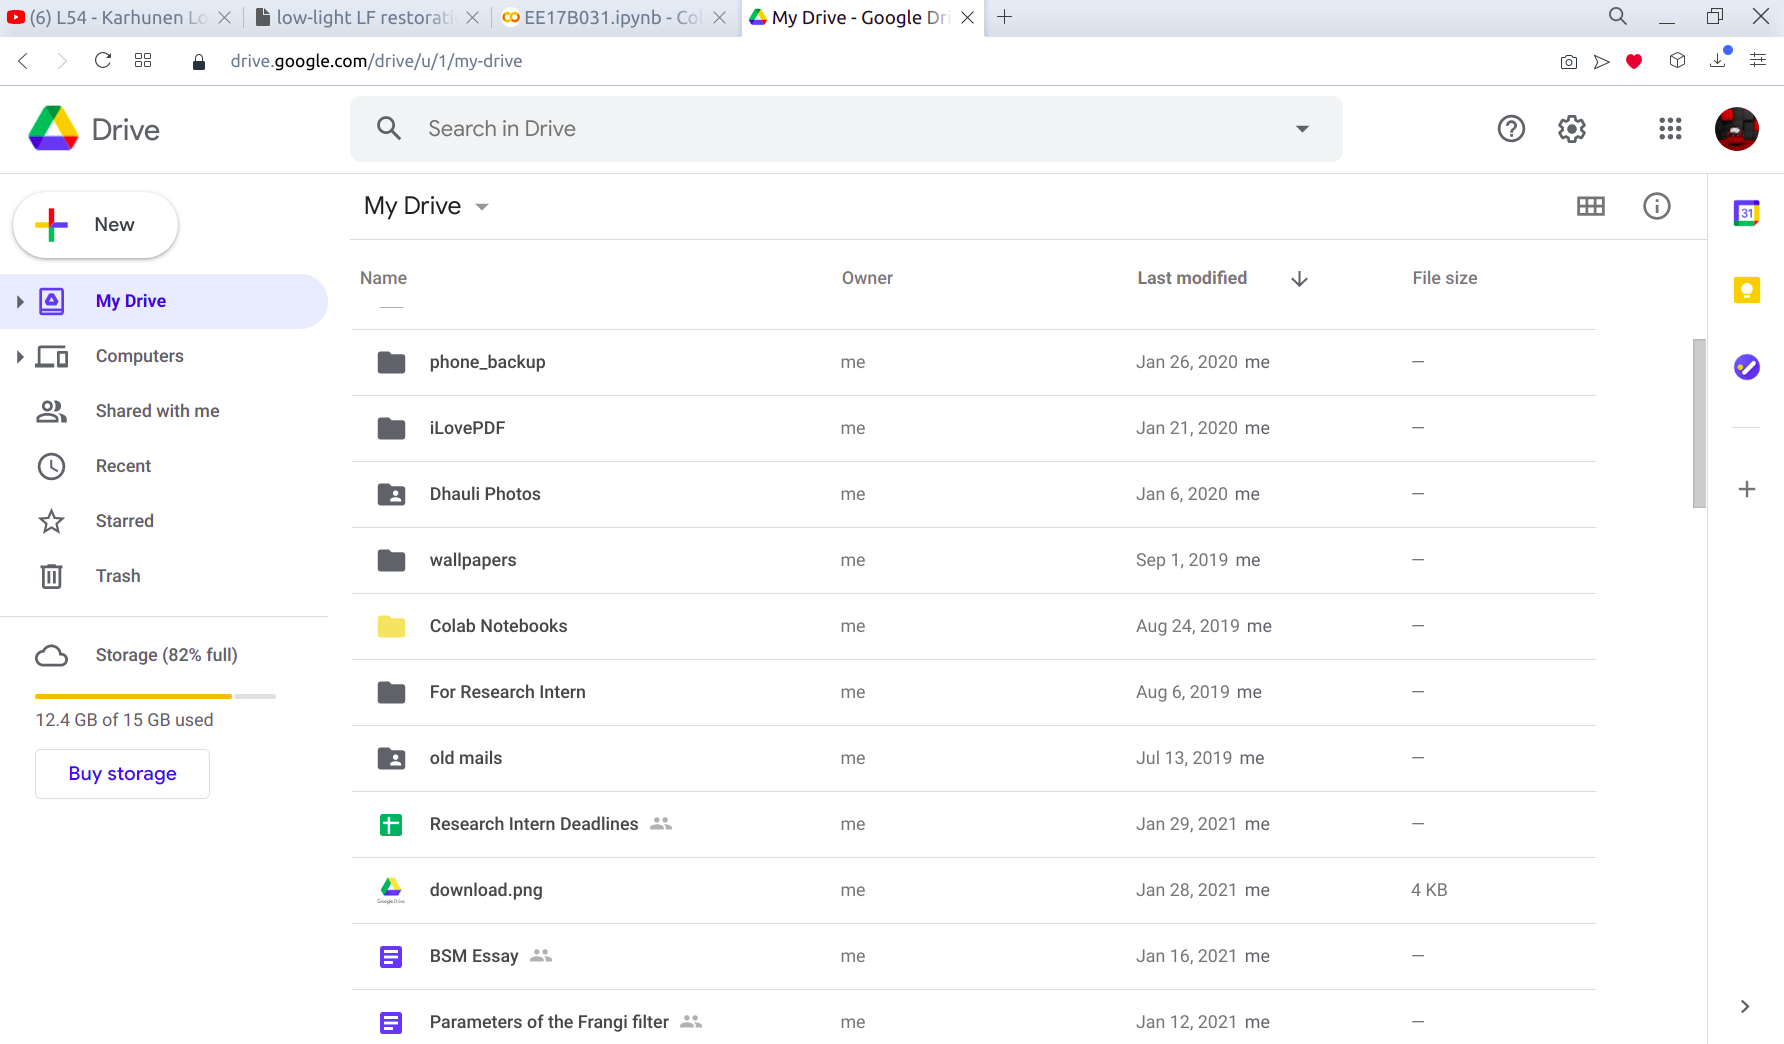

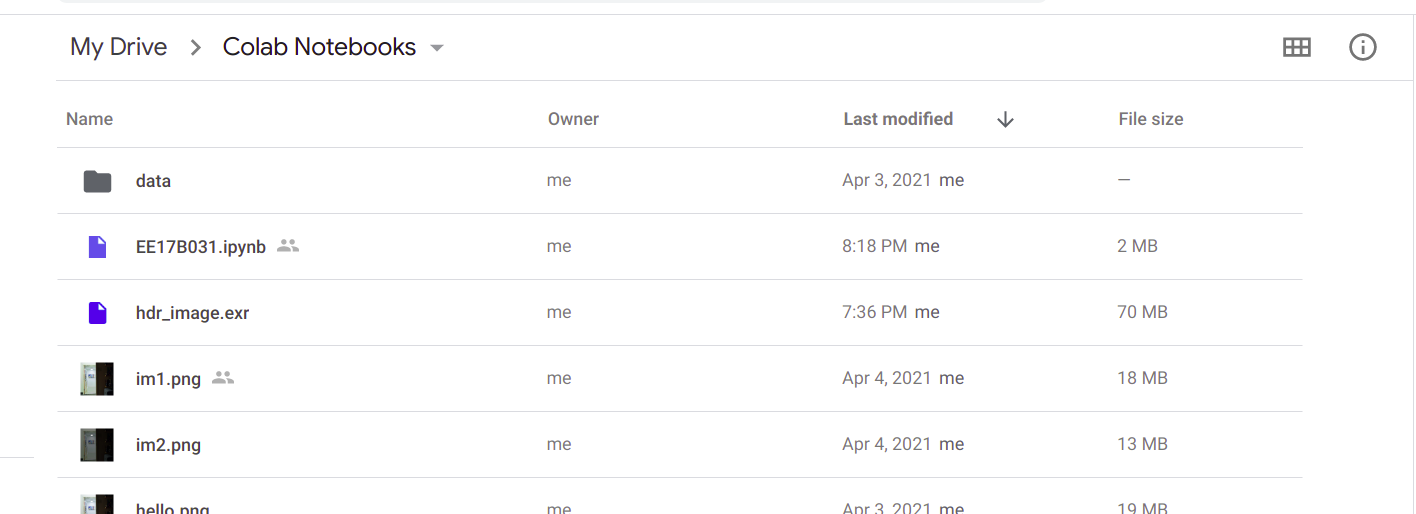

In [2]:
cd "drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


### Importing Libraries
All the functions are implemented from scratch. $\texttt{Imageio}$ is used for reading and writing images only.

In [3]:
import os
import numpy as np
import imageio
# for saving the .exr files
# throws up an error without this line
imageio.plugins.freeimage.download()
from imageio import imread, imwrite
import matplotlib.pyplot as plt

### Calculate Weights
Since $g(z)$ will typically have a steep slope near $Z_{min}$ and $Z_{max}$ , we should expect that $g(z)$ will be less smooth and will fit the data more poorly near these extremes. To recognize this, we can introduce a weighting function $w(z)$ to emphasize the smoothness and fitting terms toward the middle of the curve. A reasonable choice of weights is
$$
w(z) = \left\{\begin{array}{lr}
z - Z_{min}, & \text{for } z\leq \frac{1}{2}(Z_{max}+Z_{min})\\
Z_{max} - z, & \text{for } z > \frac{1}{2}(Z_{max}+Z_{min})\\
\end{array}\right\}
$$
$w(z)$ for different values of $z$ is shown. 
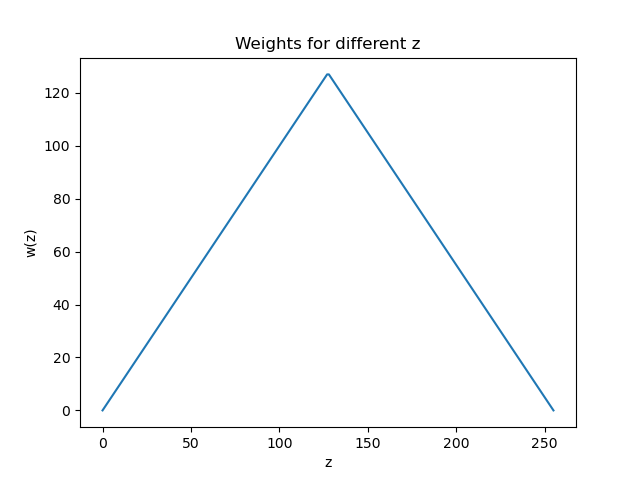

In [4]:
def w_calculator(Z_vals, n=256, Z_max=None, Z_min=None):
    if Z_max is None:
        Z_max = n-1
    if Z_min is None:
        Z_min = 0
    half_intensity = (Z_max+Z_min)/2
    w = np.zeros_like(Z_vals)
    truth_array = Z_vals <= half_intensity
    w[truth_array] = Z_vals[truth_array] - Z_min
    w[~truth_array] = Z_max - Z_vals[~truth_array]
    return w

### Reading Images
Define a function to read all images with a certain extension and a pattern of names located in a folder. A dictionary is returned.

In [5]:
def read_images(filename_base='exposure', n_exp_vals=16, filetype='jpg', folder='data'):
    all_images = {}
    print(f"Reading {n_exp_vals} images...")
    for i in range(1, n_exp_vals+1):
        filename = filename_base+str(i)+'.'+filetype
        filepath = os.path.join(folder, filename)
        image = imread(filepath)
        all_images[i] = image
    return all_images

### Formatting Images
Define a function to take the image dictionary and return three $\texttt{NumPy}$ arrays of the shape $(n, x\times y)$ for each of the R, G, and B channels. $n$ is the number of images and each image is of the shape $(x, y, 3)$. 

In [6]:
def format_images(image_dict):
    keys = list(image_dict.keys())
    n_images = len(keys)
    x, y, _ = np.shape(image_dict[keys[0]])
    r = np.zeros((n_images, x*y), dtype=np.uint8)
    g = np.zeros((n_images, x*y), dtype=np.uint8)
    b = np.zeros((n_images, x*y), dtype=np.uint8)
    print(f"Formatting {n_images} images to be in the required shape...")
    for i in range(n_images):
        key = keys[i]
        image = image_dict[key]
        r[i, :] = np.ravel(image[:, :, 0])
        g[i, :] = np.ravel(image[:, :, 1])
        b[i, :] = np.ravel(image[:, :, 2])
    return r, g, b

### Number of Points
Define a function to choose the number of points to sample. Ideally a sufficient number of points $N$ is given by
$$
N = \lceil \frac{Z_{max}-Z_{min}}{P-1} \rceil + 1
$$
where $P$ is the number of images. However, if we randomly choose just the sufficient number of points, we might get points which are always $0$ and their values are dependent on noise only or saturated pixels which convey no information. For robustness, we choose a much higher number of samples than the minimum required. We also vary the number of points depending on the size of the image. For larger images, it is logical to choose a higher number of points as some regions of the image might have a very different brightness profile compared to others and it would be nice to have information from all regions.

In [7]:
def get_N(image_dict, Z_max, Z_min, im_size_fraction = 0.00001, scale_factor = 20):
    keys = list(image_dict.keys())
    n_images = len(keys)
    x, y, _ = np.shape(image_dict[keys[0]])
    imsize = x*y
    min_points = scale_factor*((Z_max-Z_min)//n_images+1)
    N = max(im_size_fraction*imsize, min_points)
    return int(min(N, imsize))

### gsolve
A Python implementation of the MATLAB $\texttt{gsolve}$ function as given at the end of **Paul E Debevec and Jitendra Malik, "Recovering high dynamic range radiance maps from photographs," in ACM SIGGRAPH *2008 classes*, pp. 1-10. 2008.** The paper can be found [here](https://people.eecs.berkeley.edu/~malik/papers/debevec-malik97.pdf). The function here is named $gsolve\_grayscale$ as we solve for an individual channel.

In [8]:
def gsolve_grayscale(Z, B, l, w, n=256, return_lE=False):
    x, y = np.shape(Z)

    A = np.zeros((x*y+n+1, n+x))
    x_, _ = np.shape(A)
    b = np.zeros((x_, 1))

    k = 0
    for i in range(x):
        for j in range(y):
            wij = w[int(Z[i, j])]
            A[k, int(Z[i, j])] = wij
            A[k, n+i] = -wij
            b[k] = wij * B[j]
            k += 1

    A[k, int(np.ceil(n/2))] = 1
    k = k+1

    for i in range(n-2):
        A[k, i] = l*w[i+1]
        A[k, i+1] = -2*l*w[i+1]
        A[k, i+2] = l*w[i+1]
        k += 1

    x = (np.linalg.pinv(A))@b
    g = x[:n]

    if return_lE:
        lE = x[n:]
        return g, lE
    else:
        return g

### Sampling Points
A sampling function to choose a given number of points from the stack of flattened images. The parameter $\texttt{threshold}$ tries to choose points whose pixel values are in the range ($Z_{max}- threshold, Z_{min} + threshold$) so that we can escape points close to $Z_{min}$, which may be dominated by noise values or points close to $Z_{max}$, which correspond to saturated pixels. However, there is the possibility that enough pixels satisfying these conditions might not exist for all of the exposures. In that case we try to maximize the number of exposures for which we can satisfy points with the given constraints and have enough points to sample too.

In [9]:
def sampler(r_, g_, b_, n_points, Z_max=255, Z_min=0, threshold=50):
    n_images, _ = np.shape(r_)
    Z_low = Z_min + threshold
    Z_high = Z_max - threshold
    for i in range(n_images+1):
        criteria = n_images - i
        truth_vals = (r_ >= Z_low)*(r_ <= Z_high)*(g_ >= Z_low) * \
            (g_ <= Z_high)*(b_ >= Z_low)*(b_ <= Z_high)
        n_images_satisfying = np.sum(truth_vals, axis=0)
        available_indices = n_images_satisfying >= criteria
        if np.sum(available_indices) >= n_points:
            print(
                f"Choosing {n_points} points which lie between {Z_low} and {Z_high} in at least {criteria} images...")
            r_ = r_[:, available_indices]
            g_ = g_[:, available_indices]
            b_ = b_[:, available_indices]
            _, y = np.shape(r_)
            indices = np.random.choice(
                np.arange(y), size=n_points, replace=False)
            r = r_[:, indices]
            g = g_[:, indices]
            b = b_[:, indices]
            return r, g, b

### gsolve RGB
Apply the $gsolve\_grayscale$ function on each of the R, G, and B channels and return a $\texttt{NumPy}$ array of the shape $(3, x\times y)$ where each of the original images at different exposures is of the shape $(x, y, 3 )$.

In [10]:
def gsolve_RGB(r_, g_, b_, B, l, w, n_points, n=256, threshold=20):
    r, g, b = sampler(r_, g_, b_, n_points, threshold=threshold)
    g_r = gsolve_grayscale(r.T, B, l, w, n)
    g_g = gsolve_grayscale(g.T, B, l, w, n)
    g_b = gsolve_grayscale(b.T, B, l, w, n)

    return g_r, g_g, g_b,

### Tone Mapping
Function to perform tone mapping on the HDR image so that it can be displayed. Given pixel values $I_{ij, HDR}$ of a linear HDR image, photographic tonemapping is performed as 
$$
I_{ij, TM} = \frac{\bar{I}_{ij, HDR}(1+\frac{\bar{I}_{ij, HDR}}{I_{white}^{2}})}{1 + \bar{I}_{ij, HDR}}
$$

$$
I_{white} = B.max_{i,j}(\bar{I}_{ij, HDR})
$$

$$
\bar{I}_{ij, HDR} = \frac{K}{I_{m, HDR}}I_{ij, HDR}
$$

$$
I_{m, HDR} = exp\left[\frac{1}{N}\Sigma_{i,j}log_{e}(I_{ij, HDR} + \epsilon)\right]
$$

The parameter $K$ is the key, and determines how bright or dark the resulting tonemapped rendition is. The parameter $B$ is the burn, and can be used to suppress the contrast of the result. Finally, $N$ is the number of pixels, and $\epsilon$ is a small constant to avoid the singularity of the logarithm function at $0$. 

In [11]:
def tone_map_grayscale(I, K=0.15, B=0.95, epsilon=1e-12, set_I_white_inf=False):
    I_m = np.exp(np.mean(np.log(I+epsilon)))
    I_bar = K*I/I_m
    if not set_I_white_inf:
        I_white = B*np.max(I_bar)
    else:
        I_white = np.inf
    I_TM = I_bar*(1+(I_bar/(I_white**2)))/(1+I_bar)
    return I_TM

### Parameters of Capture
Set the parameters used in the process. We are given images with 16 different exposures all of which are captured with the same aperture and ISO with only the exposure times different. The exposure times are equal to
$$
\frac{2^{k-1}}{2048}, \quad \quad k \in \{1, 2, .., 16\}
$$

In [12]:
n_exp_vals = 16
scale_factor = 2048
k = np.arange(n_exp_vals)
B = 2**k
B = np.log(B/scale_factor)
l = 10

### Image Properties
Each of the LDR images is 8 bit, and hence their intensity values lie in the range $(0, 255)$. $w(z)$ is calculated for each of the intensity values according to the formula described earlier.

In [13]:
n = 256
Z_max = n-1
Z_min = 0
Z_vals = np.arange(n)
w = w_calculator(Z_vals, n=n, Z_max=Z_max, Z_min=Z_min)

### Reading Images
Read the images, store them in a dictionary, and get the $\texttt{NumPy}$ array containing the flattened images. Images are assumed to be present in a folder named $\texttt{data}$ which should lie in the same directory as the notebook. This is true irrespective of the notebook being run locally or on Colab.

In [14]:
filename_base = 'exposure'
filetype = 'jpg'
folder = 'data'

In [15]:
all_images = read_images(filename_base, n_exp_vals, filetype, folder)
x, y, _ = np.shape(all_images[1])
print(f"Images are of the shape {x} x {y}")
r, g, b = format_images(all_images)

Reading 16 images...
Images are of the shape 4000 x 6000
Formatting 16 images to be in the required shape...


### Camera Response Function (CRF) Estimation
The rendered $\texttt{jpeg}$ images obtained from the camera have non-linear response with respect to scene radiance. So before we can merge them into an HDR image, we first need to estimate the camera response function in order to undo this non-linearity. We use the $gsolve\_RGB$ function to get "g" for each channel. 

In [16]:
N = get_N(image_dict=all_images, Z_max=Z_max, Z_min=Z_min,
          im_size_fraction=0.00002, scale_factor=60)
x, y, _ = np.shape(all_images[1])
g_r, g_g, g_b = gsolve_RGB(r, g, b, B, l, w, n_points=N, n=n, threshold=5)

Choosing 960 points which lie between 5 and 250 in at least 11 images...


Plot the "g" values for each channel. Ideally "g" should be strictly monotinic, but due to noise or estimation errors, we see deviation from monotonicity where the pixel values are close to zero.

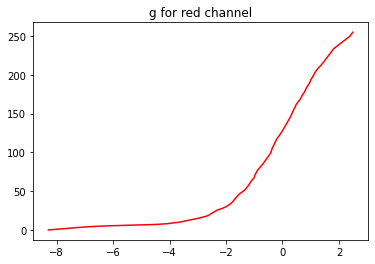

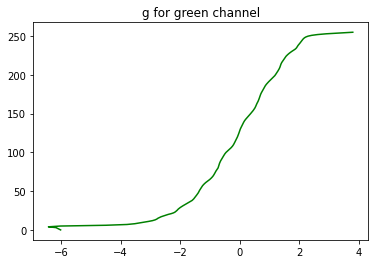

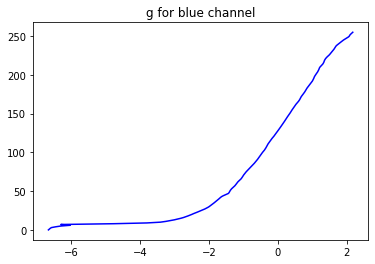

In [17]:
plt.plot(g_r, Z_vals, 'r')
plt.title("g for red channel")
plt.show()
plt.plot(g_g, Z_vals, 'g')
plt.title("g for green channel")
plt.show()
plt.plot(g_b, Z_vals, 'b')
plt.title("g for blue channel")
plt.show()

### Constructing the HDR Radiance Map
Given a set of $k$ LDR linear images corresponding to different exposures $t_{k}$, we can merge them into an HDR image. HDR image is obtained as the weighted sum of LDR images. These weights are used to place more emphasis on well-exposed pixels, and less emphasis on under-exposed or over-exposed ones from each LDR image. We implement it following the steps given in section 2.2 of Debevec and Malik. We then store the resulting HDR images as .EXR files, which is an open source high dynamic range file format.

In [18]:
try:
    del flattened_image
except:
    pass
flattened_image = np.zeros((3, x*y))
split_size = int(1e7)
_, imsize = np.shape(r)
n_splits = imsize//split_size
remainder = imsize-(n_splits*split_size)

w_vals = w_calculator(r.T, n=256)
g_ = g_r[r.T]
g_ = g_[:, :, 0]
E = np.zeros(imsize)
for i in range(n_splits):
    num = np.sum(w_vals[i*split_size:(i+1)*split_size] *
                 (g_[i*split_size:(i+1)*split_size]-B), axis=1).reshape(-1, 1)
    den = np.sum(w_vals[i*split_size:(i+1)*split_size], axis=1).reshape(-1, 1)
    E[i*split_size:(i+1)*split_size] = np.ravel(np.exp(num/den))

if remainder > 0:
    num = np.sum(w_vals[-remainder:]*(g_[-remainder:]-B),
                 axis=1).reshape(-1, 1)
    den = np.sum(w_vals[-remainder:], axis=1).reshape(-1, 1)
    E[-remainder:] = np.ravel(np.exp(num/den))

flattened_image[0] = E

w_vals = w_calculator(g.T, n=256)
g_ = g_g[g.T]
g_ = g_[:, :, 0]
E = np.zeros(imsize)
for i in range(n_splits):
    num = np.sum(w_vals[i*split_size:(i+1)*split_size] *
                 (g_[i*split_size:(i+1)*split_size]-B), axis=1).reshape(-1, 1)
    den = np.sum(w_vals[i*split_size:(i+1)*split_size], axis=1).reshape(-1, 1)
    E[i*split_size:(i+1)*split_size] = np.ravel(np.exp(num/den))

if remainder > 0:
    num = np.sum(w_vals[-remainder:]*(g_[-remainder:]-B),
                 axis=1).reshape(-1, 1)
    den = np.sum(w_vals[-remainder:], axis=1).reshape(-1, 1)
    E[-remainder:] = np.ravel(np.exp(num/den))

flattened_image[1] = E

w_vals = w_calculator(b.T, n=256)
g_ = g_b[b.T]
g_ = g_[:, :, 0]
E = np.zeros(imsize)
for i in range(n_splits):
    num = np.sum(w_vals[i*split_size:(i+1)*split_size] *
                 (g_[i*split_size:(i+1)*split_size]-B), axis=1).reshape(-1, 1)
    den = np.sum(w_vals[i*split_size:(i+1)*split_size], axis=1).reshape(-1, 1)
    E[i*split_size:(i+1)*split_size] = np.ravel(np.exp(num/den))

if remainder > 0:
    num = np.sum(w_vals[-remainder:]*(g_[-remainder:]-B),
                 axis=1).reshape(-1, 1)
    den = np.sum(w_vals[-remainder:], axis=1).reshape(-1, 1)
    E[-remainder:] = np.ravel(np.exp(num/den))

flattened_image[2] = E

Save the HDR values in a .EXR file.

In [19]:
exr_image = np.zeros((x, y, 3), dtype=np.float32)
exr_image[:, :, 0] = (flattened_image[0]).reshape(x, y)
exr_image[:, :, 1] = (flattened_image[1]).reshape(x, y)
exr_image[:, :, 2] = (flattened_image[2]).reshape(x, y)
imwrite("hdr_image.exr", exr_image.astype("float32"))

### Delete Unused Variables
Delete unused variables to clear memory, which will be needed for plotting.

In [20]:
try:
    del all_images
except:
    pass
try:
    del exr_image
except:
    pass
try:
    del r
except:
    pass
try:
    del g
except:
    pass
try:
    del b
except:
    pass

Try with the default parameters first.

In [21]:
K = 0.15
B_ = 0.95
epsilon = 1e-12

im1 = np.zeros_like(flattened_image)
im1[0] = tone_map_grayscale(flattened_image[0], K=K,
                            B=B_, epsilon=epsilon, set_I_white_inf=True)
im1[1] = tone_map_grayscale(flattened_image[1], K=K,
                            B=B_, epsilon=epsilon, set_I_white_inf=True)
im1[2] = tone_map_grayscale(flattened_image[2], K=K,
                            B=B_, epsilon=epsilon, set_I_white_inf=True)

im2 = np.zeros_like(flattened_image)
im2[0] = tone_map_grayscale(flattened_image[0], K=K,
                            B=B_, epsilon=epsilon, set_I_white_inf=False)
im2[1] = tone_map_grayscale(flattened_image[1], K=K,
                            B=B_, epsilon=epsilon, set_I_white_inf=False)
im2[2] = tone_map_grayscale(flattened_image[2], K=K,
                            B=B_, epsilon=epsilon, set_I_white_inf=False)

im1_final = np.zeros((x, y, 3))
im1_final[:, :, 0] = (im1[0]).reshape(x, y)
im1_final[:, :, 1] = (im1[1]).reshape(x, y)
im1_final[:, :, 2] = (im1[2]).reshape(x, y)

im2_final = np.zeros((x, y, 3))
im2_final[:, :, 0] = (im2[0]).reshape(x, y)
im2_final[:, :, 1] = (im2[1]).reshape(x, y)
im2_final[:, :, 2] = (im2[2]).reshape(x, y)

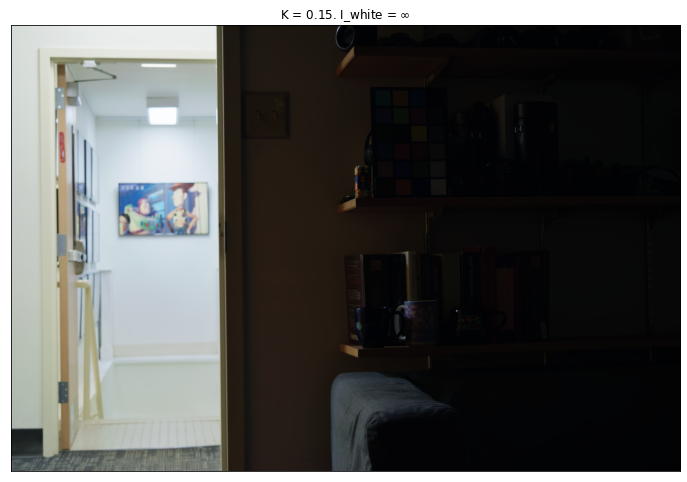

In [22]:
plt.figure(figsize=(12, 18))
plt.imshow(im1_final)
plt.xticks([])
plt.yticks([])
plt.title(rf"K = {K}. I_white = $\infty$")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


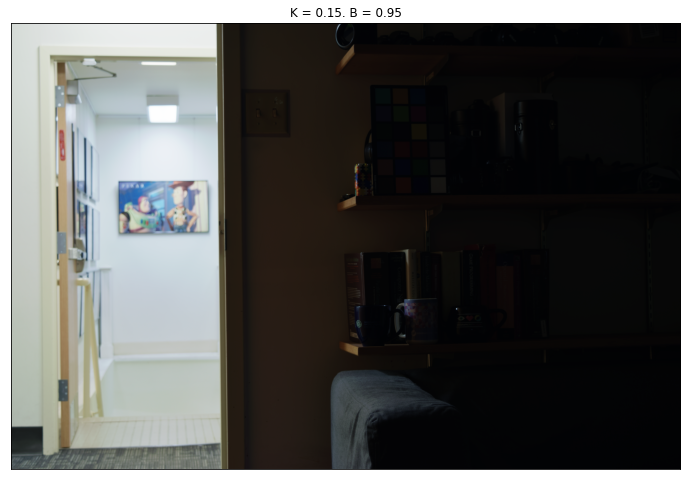

In [23]:
plt.figure(figsize=(12, 18))
plt.imshow(im2_final)
plt.xticks([])
plt.yticks([])
plt.title(f"K = {K}. B = {B_}")
plt.show()

Increasing the value of $K$. We can expect a brighter image but with the caveat that it might be over-exposed at the brighter regions.

In [24]:
try:
    del im1
except:
    pass

try:
    del im2
except:
    pass

try:
    del im1_final
except:
    pass

try:
    del im2_final
except:
    pass

K = 0.5
B_ = 0.95
epsilon = 1e-12

im1 = np.zeros_like(flattened_image)
im1[0] = tone_map_grayscale(flattened_image[0], K=K,
                            B=B_, epsilon=epsilon, set_I_white_inf=True)
im1[1] = tone_map_grayscale(flattened_image[1], K=K,
                            B=B_, epsilon=epsilon, set_I_white_inf=True)
im1[2] = tone_map_grayscale(flattened_image[2], K=K,
                            B=B_, epsilon=epsilon, set_I_white_inf=True)

im2 = np.zeros_like(flattened_image)
im2[0] = tone_map_grayscale(flattened_image[0], K=K,
                            B=B_, epsilon=epsilon, set_I_white_inf=False)
im2[1] = tone_map_grayscale(flattened_image[1], K=K,
                            B=B_, epsilon=epsilon, set_I_white_inf=False)
im2[2] = tone_map_grayscale(flattened_image[2], K=K,
                            B=B_, epsilon=epsilon, set_I_white_inf=False)

im1_final = np.zeros((x, y, 3))
im1_final[:, :, 0] = (im1[0]).reshape(x, y)
im1_final[:, :, 1] = (im1[1]).reshape(x, y)
im1_final[:, :, 2] = (im1[2]).reshape(x, y)

im2_final = np.zeros((x, y, 3))
im2_final[:, :, 0] = (im2[0]).reshape(x, y)
im2_final[:, :, 1] = (im2[1]).reshape(x, y)
im2_final[:, :, 2] = (im2[2]).reshape(x, y)

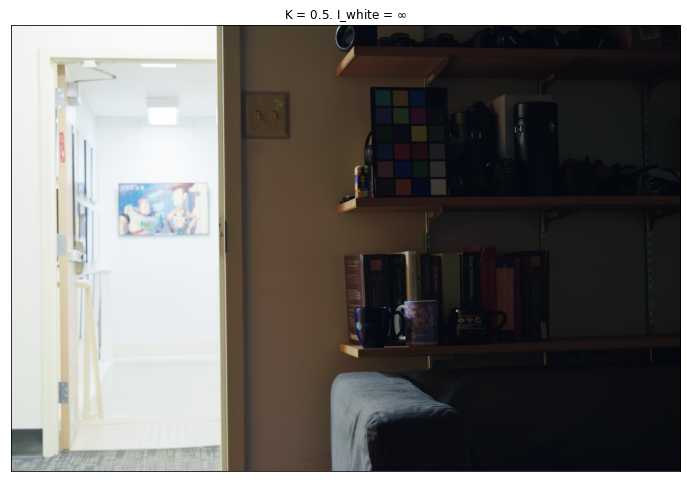

In [25]:
plt.figure(figsize=(12, 18))
plt.imshow(im1_final)
plt.xticks([])
plt.yticks([])
plt.title(rf"K = {K}. I_white = $\infty$")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


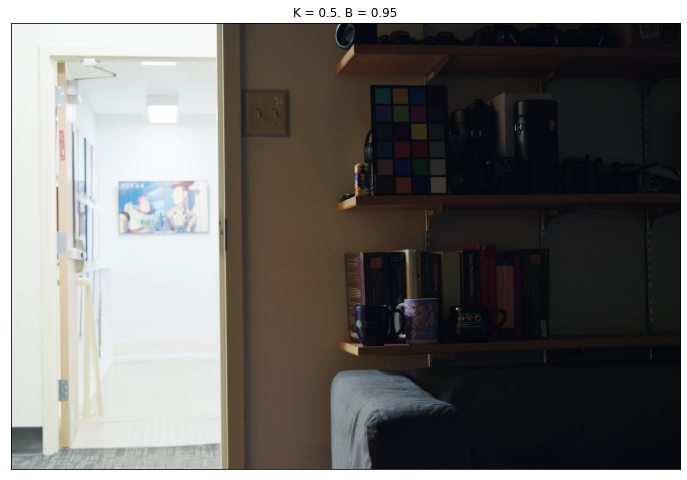

In [26]:
plt.figure(figsize=(12, 18))
plt.imshow(im2_final)
plt.xticks([])
plt.yticks([])
plt.title(f"K = {K}. B = {B_}")
plt.show()

Try changing the value of $B$. On increasing it, we expect a darker image

In [29]:
try:
    del im1
except:
    pass

try:
    del im2
except:
    pass

try:
    del im1_final
except:
    pass

try:
    del im2_final
except:
    pass

K = 0.5
B_ = 1.05
epsilon = 1e-12

im2 = np.zeros_like(flattened_image)
im2[0] = tone_map_grayscale(flattened_image[0], K=K,
                            B=B_, epsilon=epsilon, set_I_white_inf=False)
im2[1] = tone_map_grayscale(flattened_image[1], K=K,
                            B=B_, epsilon=epsilon, set_I_white_inf=False)
im2[2] = tone_map_grayscale(flattened_image[2], K=K,
                            B=B_, epsilon=epsilon, set_I_white_inf=False)

im2_final = np.zeros((x, y, 3))
im2_final[:, :, 0] = (im2[0]).reshape(x, y)
im2_final[:, :, 1] = (im2[1]).reshape(x, y)
im2_final[:, :, 2] = (im2[2]).reshape(x, y)

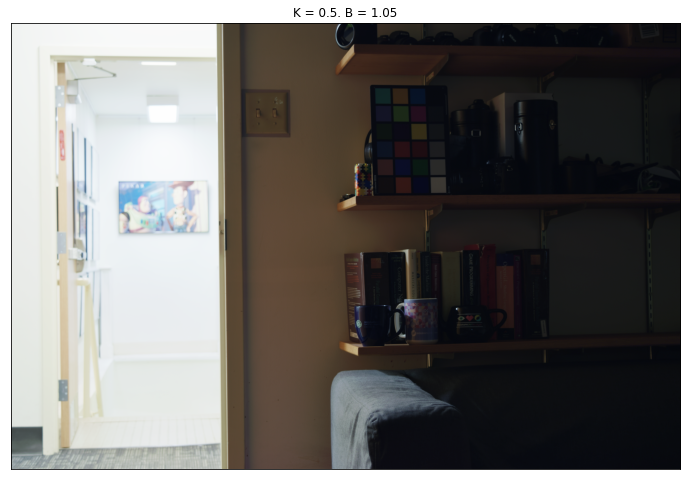

In [30]:
plt.figure(figsize=(12, 18))
plt.imshow(im2_final)
plt.xticks([])
plt.yticks([])
plt.title(f"K = {K}. B = {B_}")
plt.show()

In [31]:
try:
    del im1
except:
    pass

try:
    del im2
except:
    pass

try:
    del im1_final
except:
    pass

try:
    del im2_final
except:
    pass

K = 0.5
B_ = 2
epsilon = 1e-12

im2 = np.zeros_like(flattened_image)
im2[0] = tone_map_grayscale(flattened_image[0], K=K,
                            B=B_, epsilon=epsilon, set_I_white_inf=False)
im2[1] = tone_map_grayscale(flattened_image[1], K=K,
                            B=B_, epsilon=epsilon, set_I_white_inf=False)
im2[2] = tone_map_grayscale(flattened_image[2], K=K,
                            B=B_, epsilon=epsilon, set_I_white_inf=False)

im2_final = np.zeros((x, y, 3))
im2_final[:, :, 0] = (im2[0]).reshape(x, y)
im2_final[:, :, 1] = (im2[1]).reshape(x, y)
im2_final[:, :, 2] = (im2[2]).reshape(x, y)

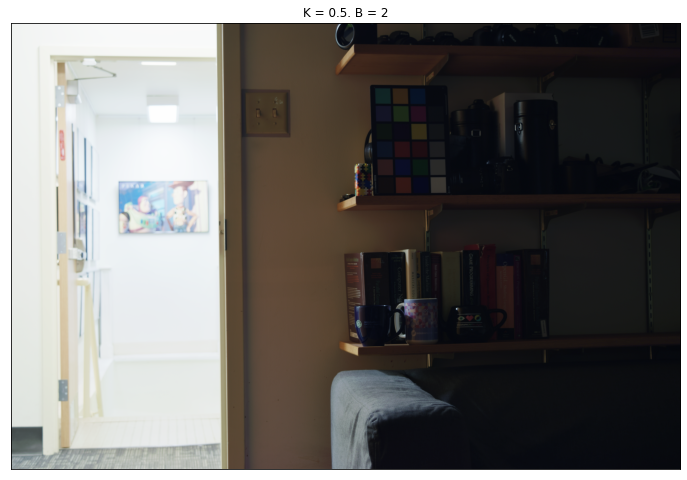

In [32]:
plt.figure(figsize=(12, 18))
plt.imshow(im2_final)
plt.xticks([])
plt.yticks([])
plt.title(f"K = {K}. B = {B_}")
plt.show()

In [34]:
try:
    del im1
except:
    pass

try:
    del im2
except:
    pass

try:
    del im1_final
except:
    pass

try:
    del im2_final
except:
    pass

K = 0.5
B_ = 0.01
epsilon = 1e-12

im2 = np.zeros_like(flattened_image)
im2[0] = tone_map_grayscale(flattened_image[0], K=K,
                            B=B_, epsilon=epsilon, set_I_white_inf=False)
im2[1] = tone_map_grayscale(flattened_image[1], K=K,
                            B=B_, epsilon=epsilon, set_I_white_inf=False)
im2[2] = tone_map_grayscale(flattened_image[2], K=K,
                            B=B_, epsilon=epsilon, set_I_white_inf=False)

im2_final = np.zeros((x, y, 3))
im2_final[:, :, 0] = (im2[0]).reshape(x, y)
im2_final[:, :, 1] = (im2[1]).reshape(x, y)
im2_final[:, :, 2] = (im2[2]).reshape(x, y)

Decreasing $B$ to a much lower value. We expect an image which is over-exposed in the brighter regions.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


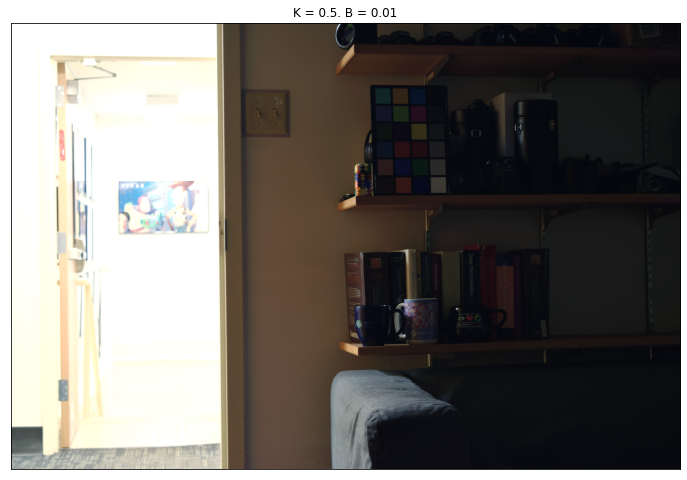

In [35]:
plt.figure(figsize=(12, 18))
plt.imshow(im2_final)
plt.xticks([])
plt.yticks([])
plt.title(f"K = {K}. B = {B_}")
plt.show()

### Observations
The following observations can be made.
- Ideally "g" should be strictly monotinic, but due to noise or estimation errors, we see deviation from monotonicity where the pixel values are close to zero.
- Varying $B$ around the given value does not make a lot of perceptual difference. 
- Increasing K increases the image brightness and vice versa. This is as expected.
- Decreasing $B$ to really small values results in an image with a slightly different white balance which is over-exposed in the brighter regions.
- When $I_{white}$ is set to $\infty$, all of the pixel values in the resulting tone mapped image lie in the range $(0,1)$. This means we do not need to do any sort of clipping before displaying it. 
- In the other case, some pixel values are greater than 1, which means we have to clip them to 1 before displaying.
- A lot more detail is present in the HDR images than shown here. These can be retrieved using a better tone mapping algorithm. An example generated using the Reinhard tone mapper is shown below.

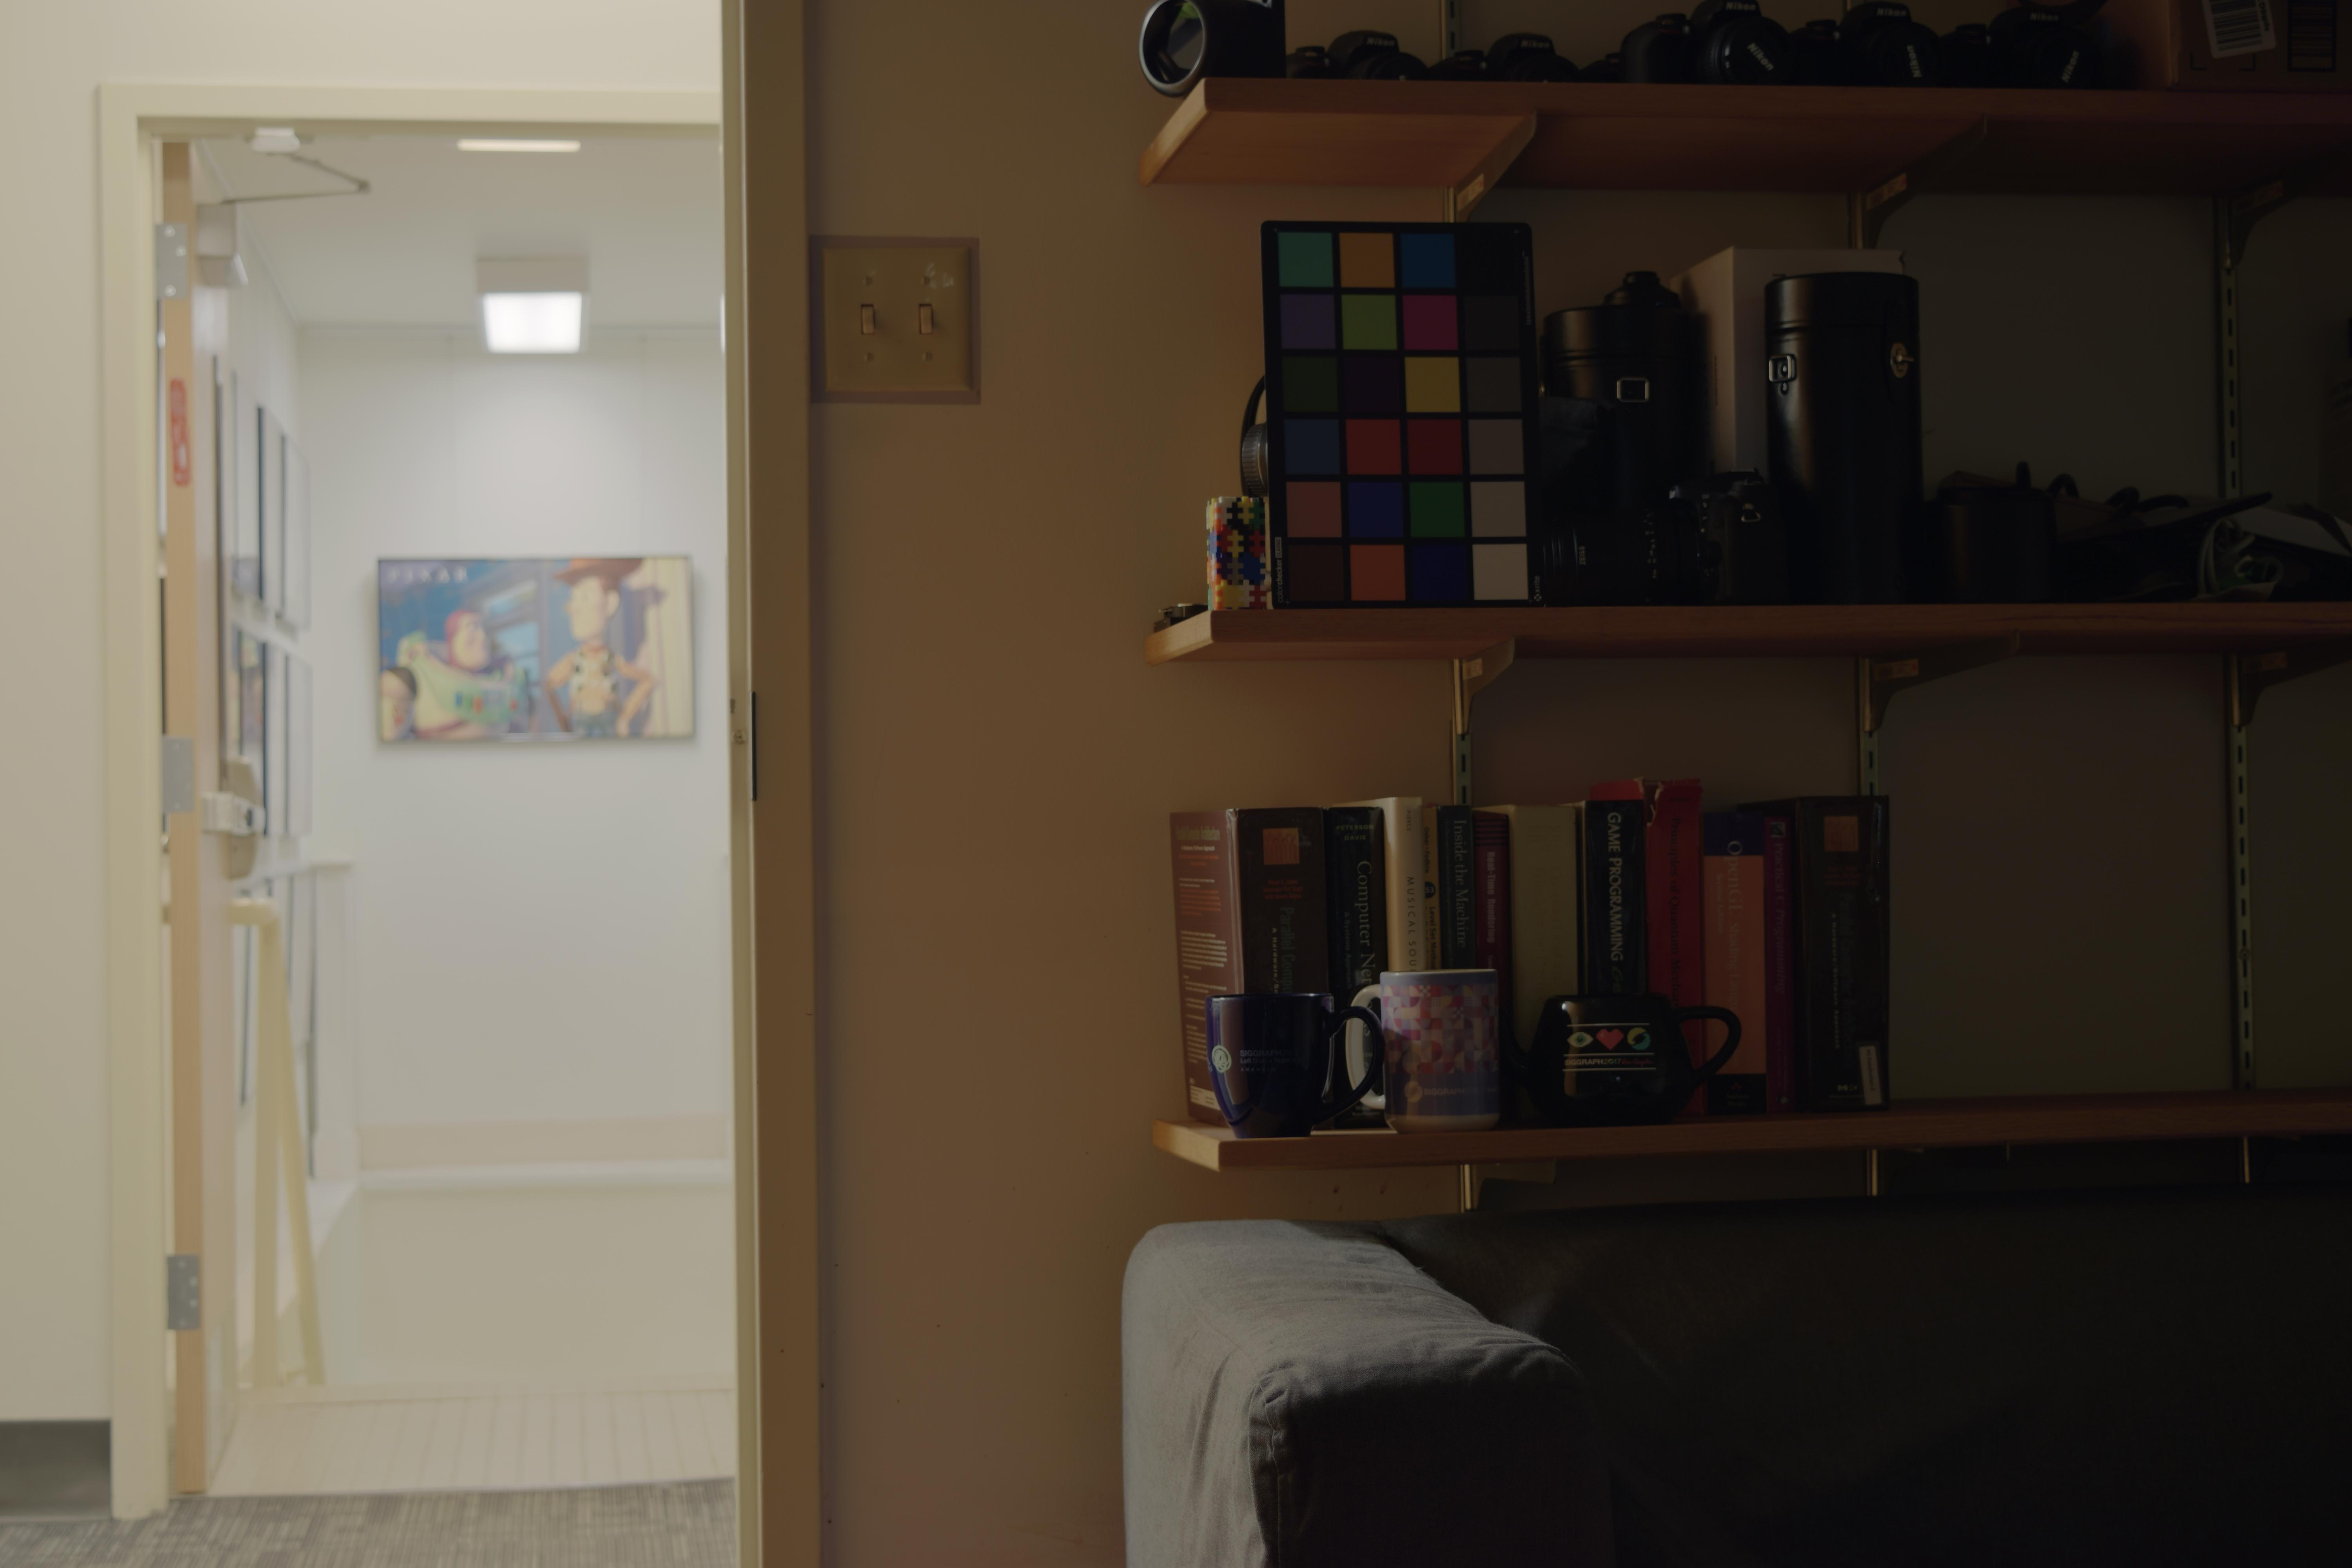